In [1]:
import pandas as pd

In [3]:
data = pd.read_csv(r'/forestfires.csv')
print(data.shape)
data.head()

(517, 31)


,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small


In [4]:
# retreiving dummy variable columns for better analysis of data :
original_data = data.iloc[:,0:11]
# print(original_data.shape)     # (517, 11)
original_data.head()
original_data["size_category"] = data["size_category"]
print(original_data.shape)       # (517, 12)

(517, 12)


In [5]:
# Remove out liers in FFMC :
original_data["FFMC"] = original_data["FFMC"].loc[original_data["FFMC"]>80]

In [8]:
# Remove outliers from data base on  distibution :
# original_data["ISI"] = original_data[original_data.ISI<40]
original_data["rain"] = original_data["rain"].loc[original_data.rain<2.5]
original_data["area"] = original_data["area"].loc[original_data.area<400]
# original_data.tail()
original_data["ISI"] = original_data["ISI"].loc[original_data.ISI < 40]

In [9]:
original_data = original_data.dropna(axis=0)

In [10]:
dummy_data = pd.get_dummies(original_data)
print(dummy_data.shape)        # (501, 29)

(501, 29)


In [11]:
# Feature Selection Method : Tree Based feature selection 
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
y = dummy_data["area"]
x = dummy_data.drop(["area"], axis=1)

In [12]:
model.fit(x,y)
model.feature_importances_

array([1.36415337e-01, 6.48217798e-02, 5.88019035e-02, 7.75395023e-02,
       1.87243142e-01, 4.17524529e-02, 1.44885072e-01, 8.87543356e-06,
       0.00000000e+00, 6.50463057e-07, 5.73735952e-05, 6.89822494e-08,
       0.00000000e+00, 1.22055797e-06, 8.34567857e-07, 8.15600998e-06,
       0.00000000e+00, 6.27220125e-04, 8.40380829e-04, 7.09226762e-05,
       2.55710048e-04, 3.19284746e-03, 3.04840037e-05, 7.69503689e-04,
       1.35667157e-02, 1.65576068e-05, 2.69093289e-01, 0.00000000e+00])

In [13]:
import numpy as np
# to get columns index which has high impact to predict area :
l = model.feature_importances_>0.01
print("Index of columns which has high impact :", np.where(l==True))

Index of columns which has high impact : (array([ 0,  1,  2,  3,  4,  5,  6, 24, 26]),)


# Here, we can observe that individually month_august , month_september , month_july has high impact but in case of combining whole feature together month_april has high impact on area.

In [14]:
final_x = dummy_data.iloc[:,[0,  1,  2,  3,  4,  5,  6, 24, 26]]
final_x.shape

(501, 9)

In [15]:
import keras
from sklearn.preprocessing import StandardScaler
# Standardization
a = StandardScaler()
a.fit(final_x)
x_standardized = a.transform(final_x)

In [16]:
# Importing the necessary packages
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam, Adadelta

In [18]:
# create base model :
kfold = KFold(n_splits=10)
def create_model():
  m = Sequential()
  m.add(Dense(16, input_dim=9, kernel_initializer='normal', activation='relu'))
  m.add(Dense(12, kernel_initializer='normal', activation='relu'))
  m.add(Dense(8, kernel_initializer='normal', activation='relu'))
  m.add(Dense(1, kernel_initializer='normal'))
  adam = Adam(lr=0.01)
  m.compile(loss='mean_squared_error', optimizer=adam)
  return m
model = create_model()
history_1 = model.fit(np.array(x_standardized), np.array(y), epochs=100)
print("********************************done***********************************")

Epoch 1/100
16/16 [==============================] - 2s 2ms/step - loss: 856.5717
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 928.4283
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 862.9008
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 573.7295
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 672.2999
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 558.8751
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 718.7888
Epoch 8/100
16/16 [==============================] - 0s 2ms/step - loss: 553.5658
Epoch 9/100
16/16 [==============================] - 0s 2ms/step - loss: 474.2340
Epoch 10/100
16/16 [==============================] - 0s 2ms/step - loss: 929.5611
Epoch 11/100
16/16 [==============================] - 0s 2ms/step - loss: 791.0137
Epoch 12/100
16/16 [==============================] - 0s 2ms/step - loss: 920.8695
Epoch 13/100


In [19]:
history_1.history.keys()

dict_keys(['loss'])

In [20]:
# prediction for base model :
y_pred = model.predict(x_standardized)

In [21]:
from sklearn.metrics import r2_score
print(r2_score(y_pred, y))       # 41.45 % 

-0.4144714404448768


Text(0, 0.5, 'actual value')

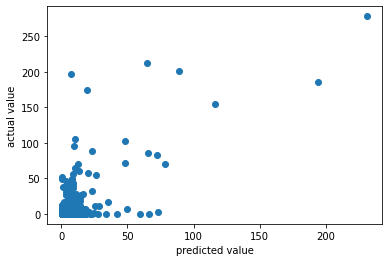

In [23]:
import matplotlib.pyplot as plt
plt.scatter(y_pred, y)
plt.xlabel("predicted value")
plt.ylabel("actual value")

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_standardized, y, test_size=0.25, random_state=7)

In [27]:
# train data on base model :
history_2 = model.fit(np.array(x_train), np.array(y_train), epochs=500)

Epoch 1/500
12/12 [==============================] - 0s 2ms/step - loss: 98.4749
Epoch 2/500
12/12 [==============================] - 0s 2ms/step - loss: 103.2954
Epoch 3/500
12/12 [==============================] - 0s 2ms/step - loss: 104.6913
Epoch 4/500
12/12 [==============================] - 0s 2ms/step - loss: 102.9873
Epoch 5/500
12/12 [==============================] - 0s 2ms/step - loss: 95.7735
Epoch 6/500
12/12 [==============================] - 0s 2ms/step - loss: 97.7983
Epoch 7/500
12/12 [==============================] - 0s 2ms/step - loss: 95.1973
Epoch 8/500
12/12 [==============================] - 0s 2ms/step - loss: 101.3646
Epoch 9/500
12/12 [==============================] - 0s 2ms/step - loss: 101.2751
Epoch 10/500
12/12 [==============================] - 0s 2ms/step - loss: 107.1635
Epoch 11/500
12/12 [==============================] - 0s 2ms/step - loss: 107.1559
Epoch 12/500
12/12 [==============================] - 0s 2ms/step - loss: 98.0544
Epoch 13/500
12/12

In [28]:
# training accuracy of base model :
y_train_pred = model.predict(x_train)

In [29]:
print("training accuracy :", r2_score(y_train_pred, y_train))     # 67.34 % training accuracy 

training accuracy : 0.6733871227667514


In [31]:
# testing accuracy :
y_test_pred = model.predict(x_test)

In [32]:
print("testing accuracy :", r2_score(y_test_pred, y_test))

testing accuracy : -3.522785673255787


In [33]:
# create general model which is use to find better parameter :
def create_model(learning_rate,dropout_rate,activation_function,init,neuron1,neuron2):
    m = Sequential()
    m.add(Dense(neuron1,input_dim = 9,kernel_initializer = init,activation = activation_function))
    m.add(Dropout(dropout_rate))
    m.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = init,activation = activation_function))
    m.add(Dropout(dropout_rate))
    m.add(Dense(1,kernel_initializer='normal'))
    
    adam = Adam(lr = learning_rate)
    m.compile(loss = 'mean_squared_error',optimizer = adam)
    return m

# Create the model

model = KerasRegressor(build_fn = create_model,verbose = 0)

# Define the grid search parameters

batch_size = [10]
epochs = [100,200,300]
learning_rate = [0.001,0.01]
dropout_rate = [0.0,0.1]
activation_function = ['relu','linear']
init = ['uniform','normal']
neuron1 = [8,14]
neuron2 = [6,9]

# Make a dictionary of the grid search parameters

param_grids = dict(batch_size = batch_size,epochs = epochs,learning_rate = learning_rate,dropout_rate = dropout_rate,
                   activation_function = activation_function,init = init,neuron1 = neuron1,neuron2 = neuron2)

# Build and fit the GridSearchCV

grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10)
grid_result = grid.fit(np.array(x_standardized),np.array(y))

print("------------------------------- Done -----------------------------")

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=6, score=-155.953, total=   4.6s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=6, score=-97.222, total=   5.9s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=6, score=-2108.024, total=   6.2s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=6 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.7s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=6, score=-440.998, total=   6.1s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=6 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   22.8s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=6, score=-1423.421, total=   5.8s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=9 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   28.6s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=9, score=-152.297, total=   4.7s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=9 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   33.3s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=9, score=-100.746, total=   6.1s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=9 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   39.4s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=9, score=-2137.244, total=   6.3s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=9 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   45.7s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=9, score=-442.203, total=   5.7s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=9 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   51.4s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=8, neuron2=9, score=-1427.580, total=   5.9s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=14, neuron2=6 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=14, neuron2=6, score=-154.145, total=   4.8s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=14, neuron2=6 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=14, neuron2=6, score=-111.363, total=   6.3s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rate=0.001, neuron1=14, neuron2=6 
[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=100, init=uniform, learning_rat

[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed: 179.9min finished


------------------------------- Done -----------------------------


In [35]:
# Summarize the results
print("------------------ Results-----------------------------------------------")
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))
print("********************* Done ************************")

------------------ Results-----------------------------------------------
Best : -831.1702133178711, using {'activation_function': 'linear', 'batch_size': 10, 'dropout_rate': 0.1, 'epochs': 300, 'init': 'normal', 'learning_rate': 0.01, 'neuron1': 14, 'neuron2': 9}
-845.1234680175781,790.8191597993882 with: {'activation_function': 'relu', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 100, 'init': 'uniform', 'learning_rate': 0.001, 'neuron1': 8, 'neuron2': 6}
-852.0140045166015,800.6304328790077 with: {'activation_function': 'relu', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 100, 'init': 'uniform', 'learning_rate': 0.001, 'neuron1': 8, 'neuron2': 9}
-846.5821823120117,786.5435938823923 with: {'activation_function': 'relu', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 100, 'init': 'uniform', 'learning_rate': 0.001, 'neuron1': 14, 'neuron2': 6}
-849.9603485107422,800.1114874129471 with: {'activation_function': 'relu', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 100, 'init

In [36]:
# after applying general model get the best hyperparameters and make another model model_1 :
def create_model(learning_rate,dropout_rate,activation_function,init,neuron1,neuron2):
    m = Sequential()
    m.add(Dense(neuron1,input_dim = 9,kernel_initializer = init,activation = activation_function))
    m.add(Dropout(dropout_rate))
    m.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = init,activation = activation_function))
    m.add(Dropout(dropout_rate))
    m.add(Dense(1,kernel_initializer='normal'))
    
    adam = Adam(lr = learning_rate)
    m.compile(loss = 'mean_squared_error',optimizer = adam)
    return m

# Create the model

model_1 = KerasRegressor(build_fn = create_model,verbose = 0)

# Define the grid search parameters

batch_size = [10]
epochs = [500]
learning_rate = [0.01]
dropout_rate = [0.0]
activation_function = ['relu']
init = ['uniform']
neuron1 = [8]
neuron2 = [8]

# Make a dictionary of the grid search parameters

param_grids = dict(batch_size = batch_size,epochs = epochs,learning_rate = learning_rate,dropout_rate = dropout_rate,
                   activation_function = activation_function,init = init,neuron1 = neuron1,neuron2 = neuron2)

# Build and fit the GridSearchCV

grid = GridSearchCV(estimator = model_1,param_grid = param_grids,cv = KFold(),verbose = 10)
grid_result = grid.fit(np.array(x_standardized),np.array(y))

print("------------------------------- Done -----------------------------")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=500, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=500, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8, score=-145.258, total=  21.4s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=500, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.4s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=500, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8, score=-475.141, total=  28.9s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=500, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.3s remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=500, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8, score=-2393.952, total=  29.9s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=500, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=500, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8, score=-1680.155, total=  28.2s
[CV] activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=500, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s


[CV]  activation_function=relu, batch_size=10, dropout_rate=0.0, epochs=500, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8, score=-1408.607, total=  28.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min finished


------------------------------- Done -----------------------------


In [37]:
# Summarize the results for new model :
print("------------------ Results-----------------------------------------------")
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))
print("********************* Done ************************")

------------------ Results-----------------------------------------------
Best : -1220.622366333008, using {'activation_function': 'relu', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 500, 'init': 'uniform', 'learning_rate': 0.01, 'neuron1': 8, 'neuron2': 8}
-1220.622366333008,816.7449226363104 with: {'activation_function': 'relu', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 500, 'init': 'uniform', 'learning_rate': 0.01, 'neuron1': 8, 'neuron2': 8}
********************* Done ************************


In [135]:
# apply hyperparameters to get better model :
import numpy as np
# Create the model :
kfold = KFold(n_splits=10)
def create_model():
    m = Sequential()
    m.add(Dense(8, input_dim=9, kernel_initializer = 'normal', activation='relu'))
    m.add(Dense(6, kernel_initializer='normal', activation='relu'))
    # m.add(Dense(3, kernel_initializer='normal', activation='linear'))
    m.add(Dense(1, kernel_initializer='normal'))
    
    adam=Adam(lr=0.01)
#     optimizer = Adadelta()
# compile model :
    m.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
    return m

final_model = create_model()
history = final_model.fit(np.array(x_standardized), np.array(y), epochs=500, batch_size=10, verbose=0)
print(history)
print("********************************done***********************************")

********************************done***********************************


In [136]:
# now apply final model on testing and training data :
mse_value, mae_value = final_model.evaluate(x_test, y_test, verbose=0)

print(mse_value)

148.7102508544922


In [137]:
# predict test data :
final_y_test_pred = final_model.predict(x_test)

0.02420879975232504


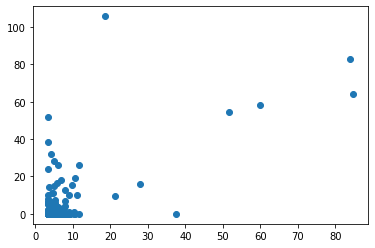

In [138]:
# testing score :
print(r2_score(final_y_test_pred, y_test))    
plt.scatter(final_y_test_pred, y_test)

In [139]:
# training data prediction :
final_y_train_pred = final_model.predict(x_train)

In [140]:
# accuracy score for training data using final_model :
print(r2_score(final_y_train_pred, y_train))    # 67.64 % training accuracy 

0.6764932789427471


No handles with labels found to put in legend.


Text(0, 0.5, 'Loss')

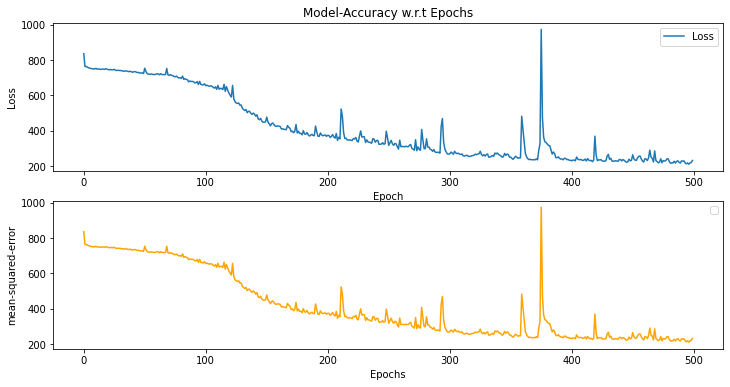

In [141]:
# visulize loss w.r.t epochs :
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,6))
ax2.plot(history.history['mse'], color='orange')
ax2.legend(loc='upper right')
ax1.plot(history.history['loss'], label='Loss')
ax1.legend(loc="upper right")
ax1.set_title("Model-Accuracy w.r.t Epochs", loc='center')
plt.xlabel("Epochs")
plt.ylabel("mean-squared-error")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")


Therefor, we can conclude that model made of extracted feature doesn't give good prediction , Thats why model made of using whole features is good model.